## 1 - Imports

In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plot_keras_history import plot_history
import warnings
from keras import backend as K
import tensorflow_probability as tfp
warnings.filterwarnings('ignore')

## 2 - Récupérer les données

On charge les données puis on retire les valeurs NaN si besoin

In [2]:
data = pd.read_csv("../databases/PEPSIR_raw_LF_perfect.csv", sep=";")
data.dropna(inplace=True)
data.head()

,river,day,reach,lon,lat,flowacc,sinuosity,meandwave,height,W,...,S,dA,K,A0,Abar,alpha,beta,Fr,U,Q
0,Connecticut,1,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,26.306667,475.403333,...,0.001768,541.200050,12.808404,515.403333,821.447783,10.945707,0.225114,0.217360,0.965178,922.263333
1,Connecticut,2,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.960000,443.906667,...,0.001606,381.870528,12.586607,515.403333,821.447783,10.945707,0.225114,0.165027,0.704906,581.980000
2,Connecticut,3,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.810000,427.006667,...,0.001539,316.600322,12.513133,515.403333,821.447783,10.945707,0.225114,0.141175,0.595232,460.586667
3,Connecticut,4,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.776667,423.786667,...,0.001521,302.424628,12.499948,515.403333,821.447783,10.945707,0.225114,0.135371,0.569428,435.253333
4,Connecticut,5,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.616667,406.016667,...,0.001469,236.099400,12.410309,515.403333,821.447783,10.945707,0.225114,0.113845,0.471288,334.273333


## 3 - Préparation des données
### 3.1 Suppresion des débits <100

In [3]:
data_river = data.loc[data['Q']>100]

### 3.2 Choisir les données

On prend 4 rivières par classe ( aléatoirement ? ) pour tester le réseaux après apprentissage

In [4]:
river_validation = ['Connecticut' , 'Po', 'Wabash','OhioSection2'] # changer pour que le tirage soit aléatoire
data_validation = data_river[data_river.river.isin(river_validation)]
data_river = data_river[~data_river.river.isin(river_validation)]

In [5]:
to_drop = ['U','Fr','alpha','beta','Abar','A0','K',
        'S','A','height','meandwave','sinuosity','lon','lat','reach','day','river']
data_river = data_river.drop(to_drop,axis=1)
data_validation = data_validation.drop(to_drop,axis=1)
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('  Shape is : ', data_river.shape)

,flowacc,W,dA,Q
627,41151.000000,205.507500,1269.139087,1672.082500
628,41151.000000,205.190000,1261.951881,1650.997500
629,41151.000000,203.932500,1229.216653,1661.297500
630,41151.000000,200.897500,1146.724416,1670.445000
631,41151.000000,195.647500,1020.369884,1603.520000


  Shape is :  (42440, 4)


### 3.2 Séparer les données


- Fonction pour séparer les données en test/train des rivières restants

In [6]:
def shuffle(d): 
    data_train = d.sample(frac=0.8, axis=0) 
    data_test  = d.drop(data_train.index)

    x_train = data_train.drop('Q',  axis=1)
    y_train = data_train['Q'] 
    x_test  = data_test.drop('Q',   axis=1)
    y_test  = data_test['Q']
    
    return x_train, y_train , x_test, y_test

### 3.3 - Data normalization

In [7]:
def normalization(x_train,y_train,x_test,y_test):
    mean = x_train.mean()
    std  = x_train.std()
    x_train = (x_train - mean) / std
    x_test  = (x_test  - mean) / std

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test,  y_test  = np.array(x_test),  np.array(y_test)
    return x_train, y_train , x_test, y_test,mean,std

# Step 4 - Build a model


### 4.1 Define custom metrics 

Pour implémenter : Pearson /  Low froude / NMRSE / KGE / NSE

- Normalized Root Mean Square Error $nRMSE(y) = \frac{RMSE(y)} {\bar y^{obs}}$


In [8]:
def nRMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))/K.mean(y_true)

- Nash-Sutcliffe model Efficiency $NSE(y) = 1 - \frac{\sum^n_{i=1}(y^{est}_i - y^{obs}_i)^2} {\sum^n_{i=1}(y^{obs}_i - \bar y^{obs})^2}$

In [9]:
def NSE(y_true, y_pred):
    return 1- K.mean(K.square(y_pred-y_true))/K.mean(K.square(y_true-K.mean(y_true)))

- Pearson correlation coefficient $R2(y) = \frac{\sum_{i=1}^{n}(y^{est}_i - \bar y^{est}) (y^{obs}_i - \bar y^{obs})} {\left(\sum_{i=1}^{n}(y^{est}_i - \bar y^{est})^2\right)^{1/2}\left(\sum_{i=1}^{n}(y^{obs}_i - \bar y^{obs})^2\right)^{1/2}}$

In [10]:
def R2(y_true,y_pred): 
    return tfp.stats.correlation(y_true, y_pred)

- Kling-Gupta model Efficiency $KGE(y) = 1 - \sqrt {(\beta_{KG}-1)^2+(\alpha_{KG}-1)^2+(R^2-1)^2}$, with $\beta_{KG}=\frac{\bar y^{est}}{\bar y^{obs}}$ and $\alpha_{KG} = \frac{\sigma(y^{est})}{\sigma(y^{obs})}$

In [11]:
def KGE(y_true,y_pred): 
    beta = K.mean(y_pred)/K.mean(y_true)
    alpha = K.var(y_pred)/K.var(y_true)
    r2 = R2(y_true,y_pred)
    kge = 1 - K.sqrt(K.square(beta-1) + K.square(alpha-1)+K.square(r2-1))
    return kge

 - Erreur de consistence basée sur low froude flow model : 

In [43]:
def LF(y_true,y_pred): 
    lf = []
    aux = y_true.shape[0]
    shape = y_true.get_shape().as_list()
    for i in range(shape[0]):
        reach_data = data[data['Q']==y_true[i]]
        A0r = reach_data["A0"]
        dArp = reach_data["dA"]
        Qrp = reach_data["Q"]
        Srp = reach_data["S"]
        Wrp = reach_data["W"]
        Zrp = reach_data["height"]
        Zr0 = np.min(Zrp)
        Wr0 = np.min(Wrp)
        c1rp = Wrp**(-2./5.) * Srp**(3./10.)
        c2rp = c1rp * dArp
        c3rp = (Zrp - Zr0)
        c4r = 1.0 / Wr0
        alpha, beta  = reach_data['alpha'] , reach_data['beta']
        Qest = (alpha**(3./5.) * (c1rp * A0r + c2rp) * (c4r * A0r + c3rp)**(3./5. * beta))**(5./3.)
        lf.append(Qest-y_pred)
    return K.mean(lf)

### 4.2 Define a model

In [44]:
def get_model_v1(shape,n_layers,n_neurons): 
  
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    
    for i in range(n_layers): 
            model.add(keras.layers.Dense(n_neurons, activation='relu', name='Dense_n'+str(i)))
   
    model.add(keras.layers.Dense(1, name='Output'))
    model.compile(optimizer = 'adam', 
                  loss      = 'mae',
                  metrics   = ['mae', 'mse',LF] )
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [45]:
shape = data_river.shape[1]-1
n_layers = 64
n_neurons = 64
model=get_model_v1((shape,),n_layers,n_neurons)
model.summary()

TypeError: 'NoneType' object cannot be interpreted as an integer

### 5.2 Train it

In [25]:
x_train, y_train , x_test, y_test = shuffle(data_river)
x_train_norm, y_train , x_test_norm, y_test, mean,std = normalization(x_train,y_train,x_test,y_test)

In [27]:
ep = 100
history = model.fit(x_train_norm,
                    y_train,
                    epochs          = ep,
                    batch_size = 100, 
                    verbose         = 1,
                    validation_data = (x_test_norm, y_test))

Train on 33952 samples, validate on 8488 samples
Epoch 1/100
33952/33952 [==============================] - 4s 111us/sample - loss: 1673.1408 - mean_absolute_error: 1673.1406 - mean_squared_error: 25635612.0000 - val_loss: 946.1621 - val_mean_absolute_error: 946.1621 - val_mean_squared_error: 6333414.0000
Epoch 2/100
33952/33952 [==============================] - 3s 76us/sample - loss: 1053.5950 - mean_absolute_error: 1053.5946 - mean_squared_error: 8751402.0000 - val_loss: 1790.9198 - val_mean_absolute_error: 1790.9198 - val_mean_squared_error: 26364044.0000
Epoch 3/100
33952/33952 [==============================] - 3s 76us/sample - loss: 1256.0013 - mean_absolute_error: 1256.0009 - mean_squared_error: 13598924.0000 - val_loss: 850.6756 - val_mean_absolute_error: 850.6755 - val_mean_squared_error: 5272452.0000
Epoch 4/100
33952/33952 [==============================] - 3s 76us/sample - loss: 928.6728 - mean_absolute_error: 928.6729 - mean_squared_error: 6949348.5000 - val_loss: 1377.77

Epoch 33/100
33952/33952 [==============================] - 3s 84us/sample - loss: 811.7569 - mean_absolute_error: 811.7569 - mean_squared_error: 5465725.0000 - val_loss: 932.4060 - val_mean_absolute_error: 932.4060 - val_mean_squared_error: 6783590.5000
Epoch 34/100
33952/33952 [==============================] - 3s 87us/sample - loss: 890.0681 - mean_absolute_error: 890.0682 - mean_squared_error: 6943616.0000 - val_loss: 729.3941 - val_mean_absolute_error: 729.3939 - val_mean_squared_error: 4270035.0000
Epoch 35/100
33952/33952 [==============================] - 3s 85us/sample - loss: 834.3313 - mean_absolute_error: 834.3314 - mean_squared_error: 5815100.5000 - val_loss: 735.8634 - val_mean_absolute_error: 735.8633 - val_mean_squared_error: 3994178.5000
Epoch 36/100
33952/33952 [==============================] - 3s 84us/sample - loss: 844.0835 - mean_absolute_error: 844.0837 - mean_squared_error: 6267672.5000 - val_loss: 684.0964 - val_mean_absolute_error: 684.0965 - val_mean_squared_

33952/33952 [==============================] - 3s 93us/sample - loss: 696.2818 - mean_absolute_error: 696.2817 - mean_squared_error: 4442396.0000 - val_loss: 673.0055 - val_mean_absolute_error: 673.0054 - val_mean_squared_error: 3242643.7500
Epoch 98/100
33952/33952 [==============================] - 3s 92us/sample - loss: 671.8157 - mean_absolute_error: 671.8158 - mean_squared_error: 3784678.0000 - val_loss: 676.2167 - val_mean_absolute_error: 676.2167 - val_mean_squared_error: 3455310.5000
Epoch 99/100
33952/33952 [==============================] - 3s 92us/sample - loss: 693.3760 - mean_absolute_error: 693.3759 - mean_squared_error: 3987606.2500 - val_loss: 608.2897 - val_mean_absolute_error: 608.2897 - val_mean_squared_error: 3103071.2500
Epoch 100/100
33952/33952 [==============================] - 3s 97us/sample - loss: 690.2684 - mean_absolute_error: 690.2684 - mean_squared_error: 4139932.5000 - val_loss: 638.7411 - val_mean_absolute_error: 638.7411 - val_mean_squared_error: 36449

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  


### 6.2 - Training history
What was the best result during our training ?

In [29]:
df=pd.DataFrame(data=history.history)
display(df.head().style.format("{0:.2f}").set_caption("Début du training:"))
display(df.tail().style.format("{0:.2f}").set_caption("Fin du training :"))

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,1673.14,1673.14,25635612.00,946.16,946.16,6333414.00
1,1053.59,1053.59,8751402.00,1790.92,1790.92,26364044.00
2,1256.00,1256.00,13598924.00,850.68,850.68,5272452.00
3,928.67,928.67,6949348.50,1377.77,1377.77,18330836.00
4,1089.60,1089.60,10489496.00,853.01,853.01,5937038.50


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,693.98,693.98,4141537.00,630.02,630.02,3181719.50
96,696.28,696.28,4442396.00,673.01,673.01,3242643.75
97,671.82,671.82,3784678.00,676.22,676.22,3455310.50
98,693.38,693.38,3987606.25,608.29,608.29,3103071.25
99,690.27,690.27,4139932.50,638.74,638.74,3644931.25


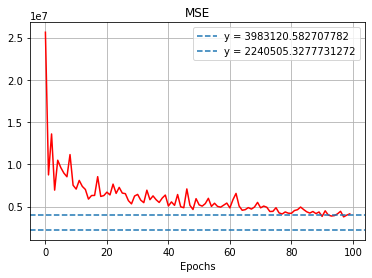

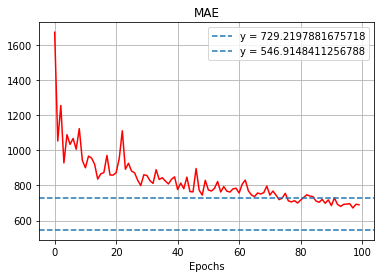

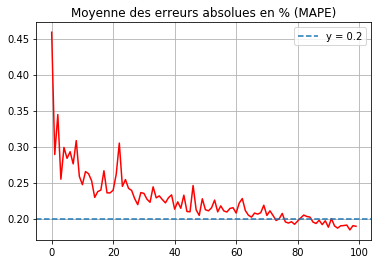

KeyError: 'nRMSE'

In [30]:
plt.plot(df['mean_squared_error'],'r')
plt.title('MSE')
plt.xlabel('Epochs')
plt.axhline(np.mean(y_train**2)*0.04,ls='--',label='y = ' + str(0.04*np.mean(y_train**2)))
plt.axhline(np.mean(y_train**2)*0.15**2,ls='--',label='y = ' + str(0.15**2*np.mean(y_train**2)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error'],'r')
plt.title('MAE')
plt.xlabel('Epochs')
plt.axhline(0.2*np.mean(y_train),ls='--',label='y = ' +str(0.2*np.mean(y_train)))
plt.axhline(0.15*np.mean(y_train),ls='--',label='y = ' +str(0.15*np.mean(y_train)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error']/np.mean(y_train),'r') # MAPE
plt.axhline(0.20,ls='--',label='y = 0.2')
plt.grid()
plt.title('Moyenne des erreurs absolues en % (MAPE)')
plt.legend()
plt.show()

""""

plt.plot(df['nRMSE'],'r')
plt.title('nRMSE')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

plt.plot(df['NSE'],'r')
plt.title('NSE')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

plt.plot(df['KGE'],'r')
plt.title('KGE')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

plt.plot(df['R2'],'r')
plt.title('R2')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()"""

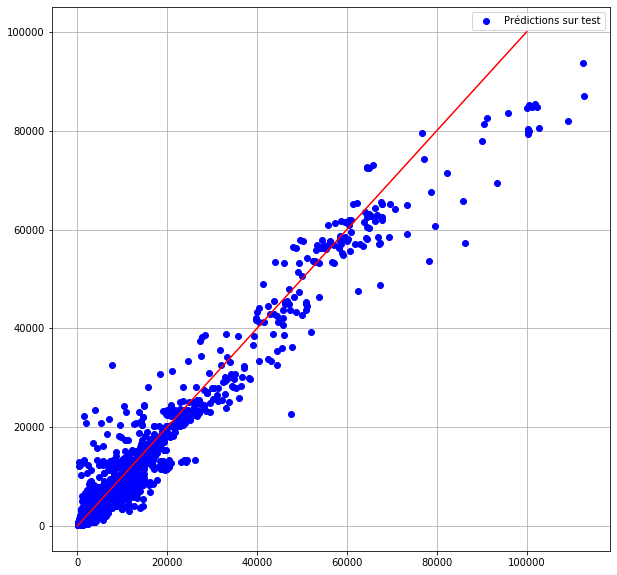

prédiction dans les 30% : 80.97313854853911 %
prédiction dans les 20% : 69.89868049010367 %
prédiction dans les 15% : 60.57964184731385 %
prédiction dans les 10% : 45.84118755890669 %


In [31]:
plt.figure(figsize=(10,10))
Qpred = model.predict(x_test_norm)
plt.plot(y_test,Qpred,'bo',label='Prédictions sur test')
x = np.arange(0,100000)
plt.plot(x,x,'r')
#plt.plot(x,x+0.20*x,'--g')
#plt.plot(x,x-0.20*x,'--g')
plt.legend()
plt.grid()
plt.show()

cont30 = 0
cont20 = 0
cont15 = 0
cont10 = 0
for i in range(0,Qpred.shape[0]):
    if Qpred[i] > 0.7*y_test[i] and Qpred[i]<1.3*y_test[i]:
        cont30+=1
    if Qpred[i] > 0.8*y_test[i] and Qpred[i]<1.2*y_test[i]:
        cont20+=1
    if Qpred[i] > 0.85*y_test[i] and Qpred[i]<1.15*y_test[i]:
        cont15+=1
    if Qpred[i] > 0.9*y_test[i] and Qpred[i]<1.1*y_test[i]:
        cont10+=1
print("prédiction dans les 30% :" ,cont30*100/Qpred.shape[0], '%')        
print("prédiction dans les 20% :" ,cont20*100/Qpred.shape[0], '%')
print("prédiction dans les 15% :" ,cont15*100/Qpred.shape[0], '%')
print("prédiction dans les 10% :" ,cont10*100/Qpred.shape[0], '%')

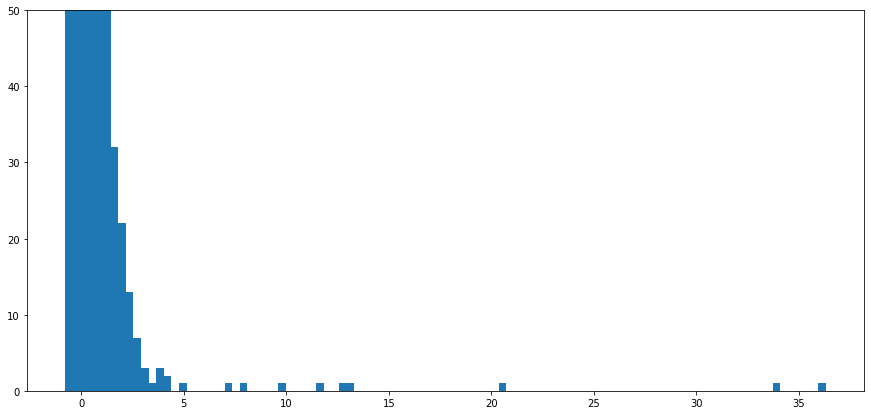

In [32]:
yt = y_test.reshape(y_test.shape[0],1)
plt.figure(figsize=(15,7))
plt.hist(((model.predict(x_test_norm)-yt)/yt),bins=100)
plt.ylim(0,50)
plt.show()

In [33]:
print(data["river"].unique())

KeyError: 'river'

In [ ]:
river_garonne = data_river[data_river["river"] == "Po"]
reach_data = river_garonne[river_garonne["reach"] ==3]

to_drop = ['U','Fr','alpha','beta','Abar','A0','K',
           'S','A','height','meandwave','sinuosity','lon','lat','reach','Q','day','river']

data = reach_data.drop(to_drop,axis=1)
data = (data - mean)/std

Qrp = reach_data["Q"]
Qpred = model.predict(data)

x = np.arange(0,Qrp.shape[0])
plt.figure(figsize=(15,5))

plt.plot(x,Qpred,'.b',label='ANN')
plt.plot(x,Qrp, 'r-',label='Target')
#plt.plot(x,Qrp+0.20*Qrp,'g--')
#plt.plot(x,Qrp-0.20*Qrp,'g--')
plt.legend()
plt.show()

cont = 0
a = Qrp.index[0]
for i in range(0,Qpred.shape[0]):
    if i+a in Qrp.index:
        if Qpred[i] > 0.8*Qrp[i+a] and Qpred[i]<1.2*Qrp[i+a]:
            cont+=1
            
print(cont*100/Qpred.shape[0], '%')

In [ ]:
#print(Qpred.reshape(1,np.shape(Qpred)[0])[0])
plt.plot((Qpred.reshape(1,np.shape(Qpred)[0])[0] -Qrp))

Remarque : 

   - Avec toutes les données, on observe des valeurs aberrantes : vers +250 (250 000% d'erreur). Cela peut s'expliquer par la présence d'une rivière avec un très faible débit. 

   - Lorsqu'on enlève les débits <70, on a perdu environ 19% des données, on observe moins le phénomène des valeurs aberrantes. ( max : 15 ). 
    
   -  Lorsqu'on enlève les débits <100, on a perdu environ 26% des données, le max est maintenant de 6. 
    
Avec des valeurs de débits assez grandes, on arrive à limiter l'erreur relative

## Save the model

In [ ]:
model.save('../Models/model_'+str(n_layers)+'_'+str(n_neurons)+'_'+str(ep))